In [1]:
import deeptime
from deeptime.decomposition import TICA
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pandas as pd
import pyemma

from deeptime.markov import TransitionCountEstimator, pcca, PCCAModel
from deeptime.markov.tools.analysis import eigenvectors
from deeptime.markov.msm import BayesianMSM, MaximumLikelihoodMSM
from deeptime.plots import plot_implied_timescales, plot_markov_model
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots.chapman_kolmogorov import plot_ck_test

%matplotlib inline

In [2]:
# # Load in trajectories
# traj_path='/dfs9/dmobley-lab/osatom/msm_project/trajectories/'

# traj_4w52 = md.load([traj_path + f'4w52_4w52/{x}/F-helix-centered.xtc' for x in range(6)], top=traj_path + '4w52_4w52/0/F-helix-centered.pdb')
# traj_4w57 = md.load([traj_path + f'4w57_4w57/{x}/F-helix-centered.xtc' for x in range(6)], top=traj_path + '4w57_4w57/0/F-helix-centered.pdb')
# traj_4w59 = md.load([traj_path + f'4w59_4w59/{x}/F-helix-centered.xtc' for x in range(6)], top=traj_path + '4w59_4w59/0/F-helix-centered.pdb')
# traj = md.join([traj_4w52, traj_4w57, traj_4w59])

# helix_top = traj_path + '4w59_4w59/0/F-helix-centered.pdb'

In [3]:
# CaCb_feat = pyemma.coordinates.featurizer(helix_top)
# ##Add Ca - Ca distances (36)
# Ca_distance_pairs = CaCb_feat.pairs(CaCb_feat.select_Ca())
# CaCb_feat.add_distances(Ca_distance_pairs, periodic=False)

# ##Add Cb - Cb distances (15)
# indices = [a.index for a in CaCb_feat.topology.atoms if a.name == 'CB']
# Cb_distance_pairs = CaCb_feat.pairs(indices)
# CaCb_feat.add_distances(Cb_distance_pairs, periodic=False)

# output = CaCb_feat.transform(traj)

In [4]:
# # Initialize TICA
# CaCb_tica = TICA(lagtime=10, epsilon=1e-6,
#                 var_cutoff=0.95).fit(output)
# CaCb_tica_output = CaCb_tica.transform(output)

### Load in TICA coordinates and microstate assignments for each system

The following TICA coordinates and microstate assignments for each system come from the MSM notebooks for each respective system. Please refer to those notebooks for further information on how these values are obtained. 

For convenience, we load in the results for all systems to analyze collectively in this notebook.

In [5]:
# def read_frames(pathname):
#     gro_traj=f'/dfs9/dmobley-lab/osatom/msm_project/{pathname}'
#     g_traj = md.formats.GroTrajectoryFile(gro_traj).read_as_traj()
#     F_helix = g_traj.top.select('(resid 106 to 114)')
#     helix = md.formats.GroTrajectoryFile(gro_traj).read_as_traj(atom_indices=F_helix)
    
#     h_ = CaCb_feat.transform(helix)
#     d_ = CaCb_tica.transform(h_)
#     return d_

In [6]:
# def TICA_convert(traj, feat):
#     data = pyemma.coordinates.load(traj, features=feat)
#     return CaCb_tica.transform(data)

In [2]:
# Load in TICA coordinates for the concatenated trajectory
CaCb_tica_output = np.load('combined_traj_TICA.npy')

In [3]:
# Load in TICA coordinates for benzene-bound systems
t_52_52 = np.load('tica/4w52_4w52_tica.npy')
t_57_52 = np.load('tica/4w57_4w52_tica.npy')
t_59_52 = np.load('tica/4w59_4w52_tica.npy')

In [4]:
# Load in TICA coordinates for butylbenzene-bound systems
t_52_57 = np.load('tica/4w52_4w57_tica.npy')
t_57_57 = np.load('tica/4w57_4w57_tica.npy')
t_59_57 = np.load('tica/4w59_4w57_tica.npy')

In [5]:
# Load in TICA coordinates for hexylbenzene-bound systems
t_52_59 = np.load('tica/4w52_4w59_tica.npy')
t_57_59 = np.load('tica/4w57_4w59_tica.npy')
t_59_59 = np.load('tica/4w59_4w59_tica.npy')

### Load in cluster classifications

In [6]:
c_52_52 = np.load('tica/4w52_4w52_cluster_assign.npy')
c_57_52 = np.load('tica/4w57_4w52_cluster_assign.npy')
c_59_52 = np.load('tica/4w59_4w52_cluster_assign.npy')

In [7]:
c_52_57 = np.load('tica/4w52_4w57_cluster_assign.npy')
c_57_57 = np.load('tica/4w57_4w57_cluster_assign.npy')
c_59_57 = np.load('tica/4w59_4w57_cluster_assign.npy')

In [8]:
c_52_59 = np.load('tica/4w52_4w59_cluster_assign.npy')
c_57_59 = np.load('tica/4w57_4w59_cluster_assign.npy')
c_59_59 = np.load('tica/4w59_4w59_cluster_assign.npy')

### Visualize implied timescale plots for each system

In the following plots, we visualize the timescales of the slowest processes of each system (different colored lines) as a function of the lag time (black line and gray region). We generally define 'slow' processes as ones that are far above the lag time. Ideally, processes should be relatively stable for different values of the lag time. We select a lag time for our MSMs as the smallest lag time where most slow processes stablize. 

In [13]:
def get_its(cluster_assign_):
    models = []
    lagtimes = np.array([100, 150, 250, 350, 500, 750, 1000])

    for lagtime in lagtimes:
        counts_estimator = TransitionCountEstimator(lagtime=lagtime, count_mode='sliding')
        counts = counts_estimator.fit(cluster_assign_).fetch_model()
        estimator = MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
        msm = estimator.fit(counts).fetch_model()
        models.append(msm)
        
    return models

In [14]:
m_52_52 = get_its(c_52_52)
m_57_52 = get_its(c_57_52)
m_59_52 = get_its(c_59_52)

In [15]:
m_52_57 = get_its(c_52_57)
m_57_57 = get_its(c_57_57)
m_59_57 = get_its(c_59_57)

In [16]:
m_52_59 = get_its(c_52_59)
m_57_59 = get_its(c_57_59)
m_59_59 = get_its(c_59_59)

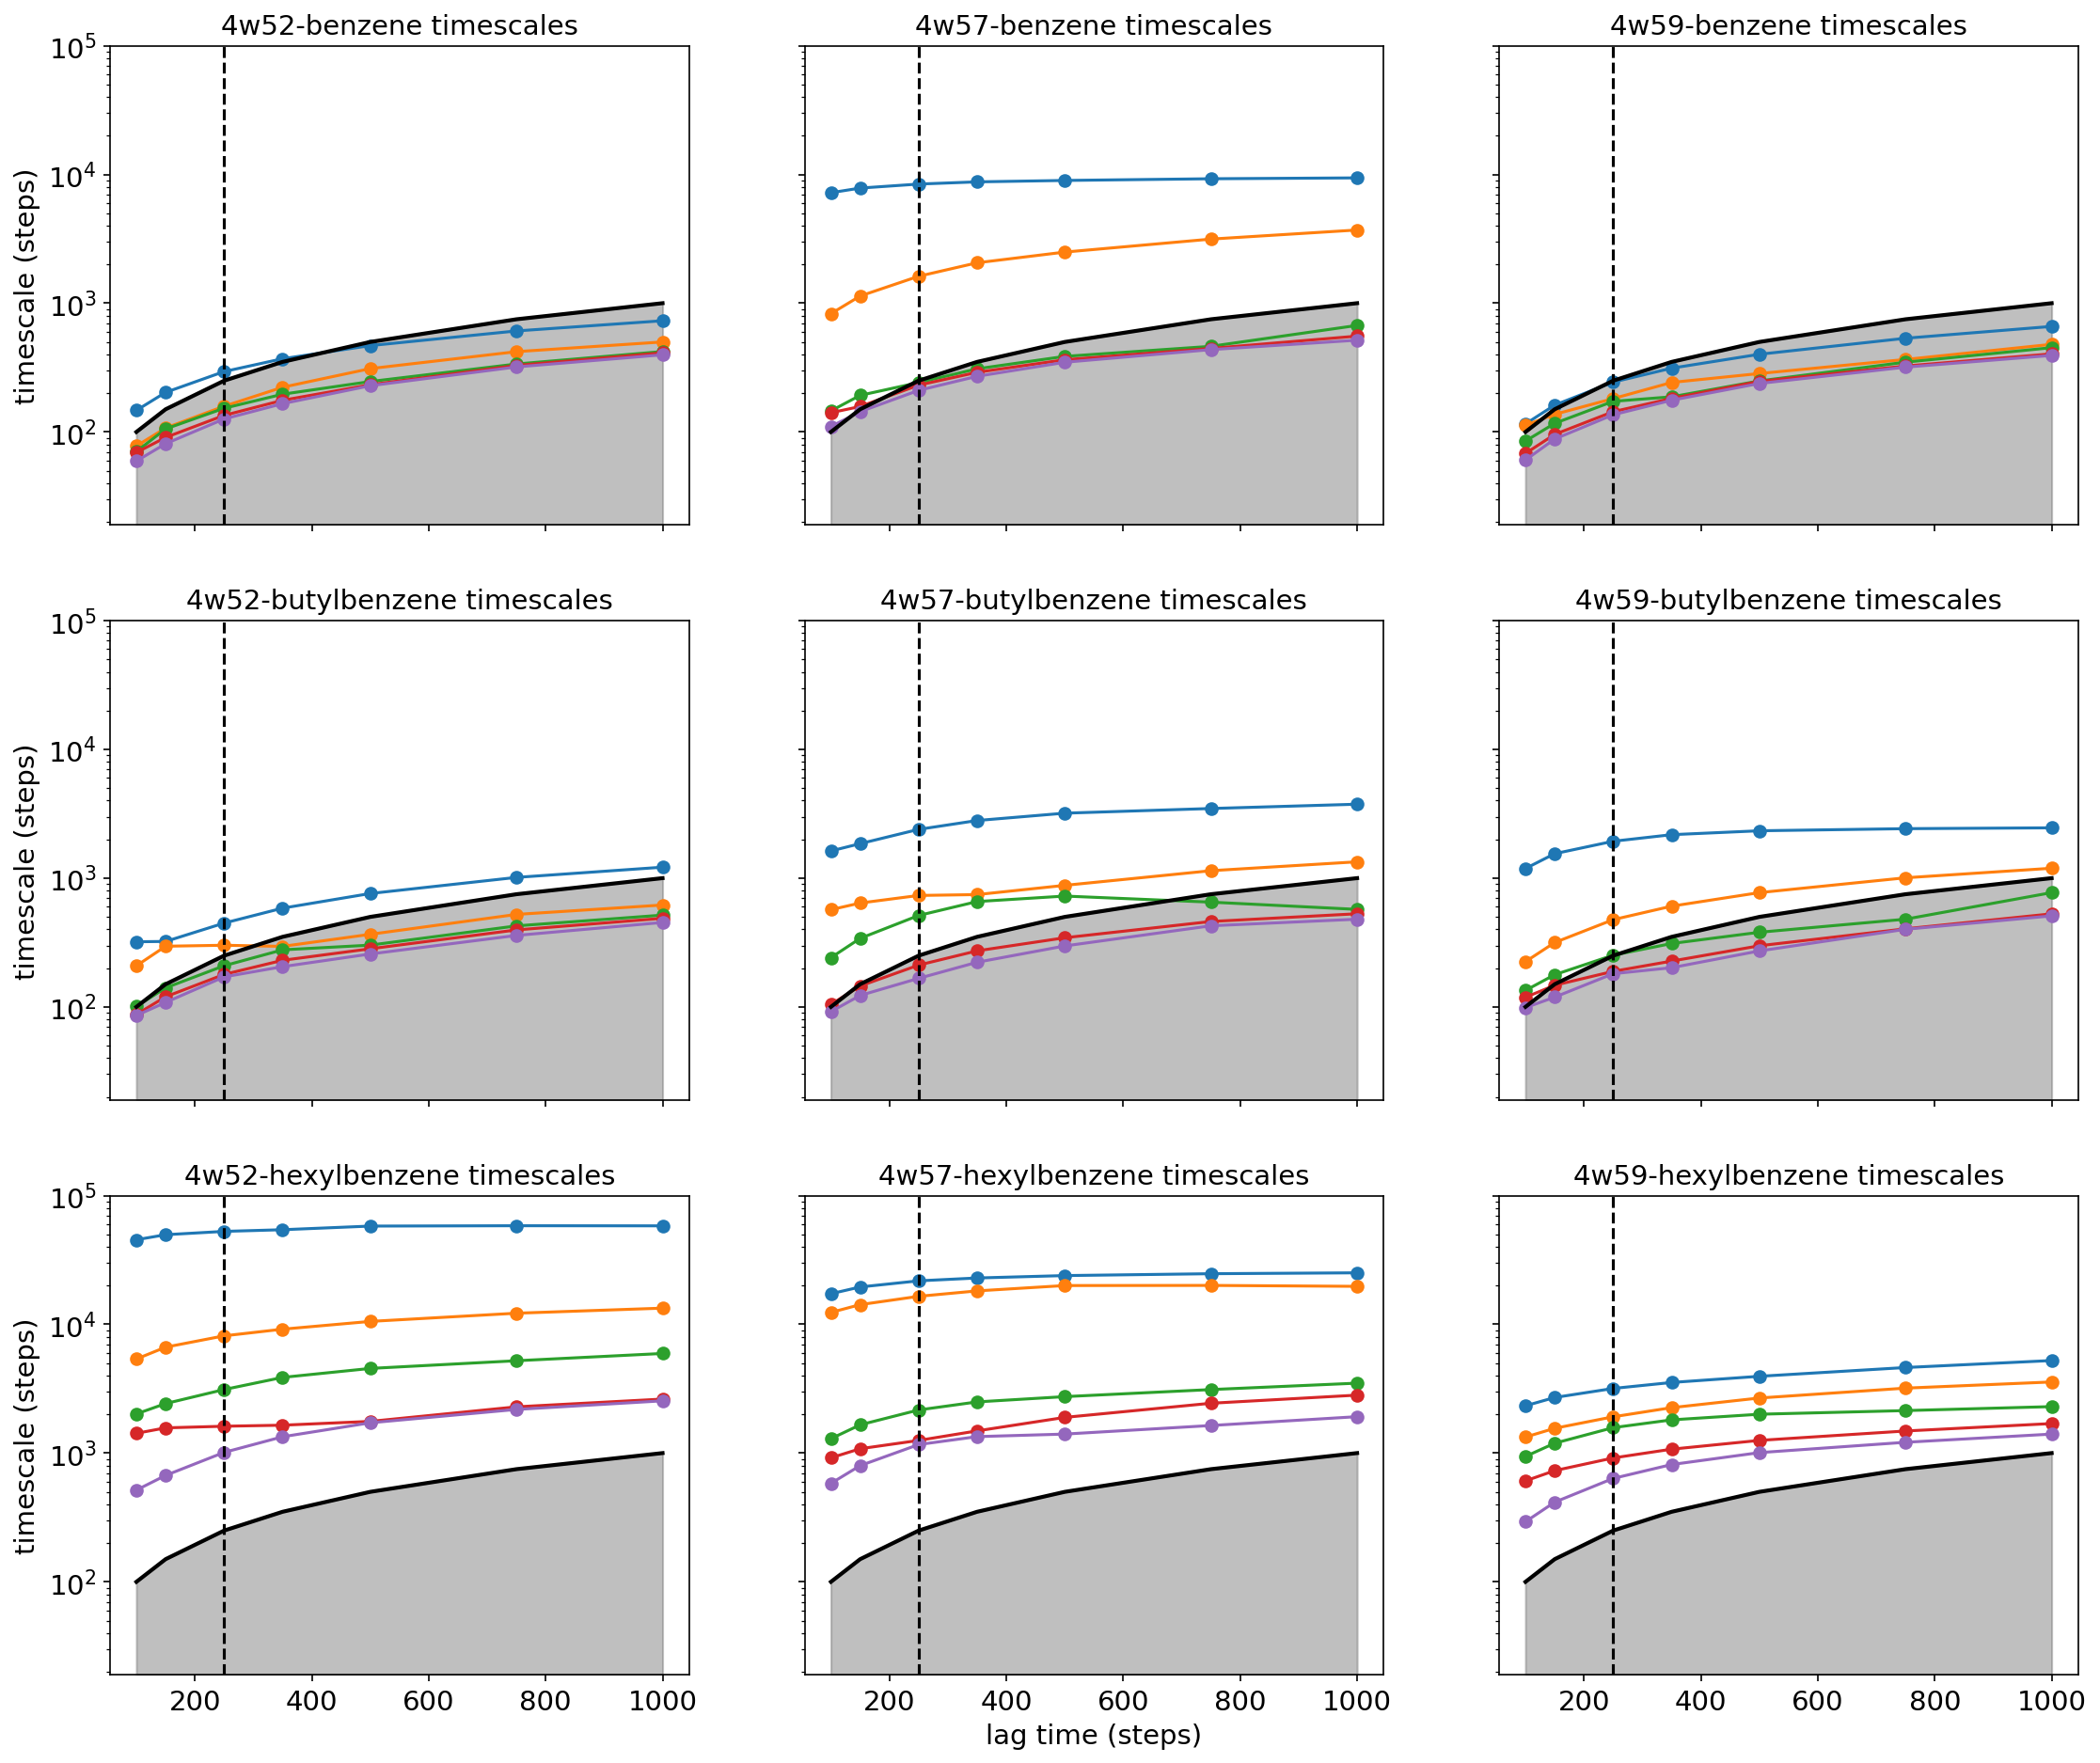

In [39]:
models = [m_52_52, m_57_52, m_59_52,
          m_52_57, m_57_57, m_59_57,
          m_52_59, m_57_59, m_59_59]
labels = ['4w52-benzene', '4w57-benzene', '4w59-benzene',
          '4w52-butylbenzene', '4w57-butylbenzene', '4w59-butylbenzene',
          '4w52-hexylbenzene', '4w57-hexylbenzene', '4w59-hexylbenzene']

fig, axs = plt.subplots(3, 3, figsize=(18,15), dpi=150, sharex=True, sharey=True)
for index, ax in enumerate(axs.reshape(-1)):
    its_data = implied_timescales(models[index])
    plot_implied_timescales(its_data, n_its=5, ax=ax, marker='o')
    ax.set_ylim([19, 10**5])
    ax.set_yscale('log')
    ax.tick_params(labelsize=14)
    ax.axvline(x=250, linestyle='dashed', color='black')
    ax.set_title(f'{labels[index]} timescales', fontsize=14)

axs[2][1].set_xlabel('lag time (steps)', fontsize=14)

axs[0][0].set_ylabel('timescale (steps)', fontsize=14)
axs[1][0].set_ylabel('timescale (steps)', fontsize=14)
axs[2][0].set_ylabel('timescale (steps)', fontsize=14)

fig.savefig('figures/implied_timescales.png')
plt.show()

## Slowest motions (eigenvectors of transition probability matrix)

Each slow motion corresponds to an eigenvector of the transition probability matrix for the given system. We can visualize these eigenvectors to get a sense of the changes in density in TICA space each of these processes corresponds to.

In [18]:
def plot_eig(tica, eig, cluster_assign):
    fig, axes = plt.subplots(1, 3, figsize=(9,3), sharey=True, dpi=150)
    for i, ax in enumerate(axes.flat):
        ax.set_xlim([-2.2, 1.2])
        ax.set_ylim([-7, 4])
        pyemma.plots.plot_contour(tica[:,0], tica[:,1], eig[cluster_assign, i+1], ax=ax, cmap='PiYG',
                                 cbar_label=f'{i+2} right eigenvector', mask=True, cbar=False)
    
    axes[0].set_ylabel('IC 2', fontsize=14)
    axes[1].set_xlabel('IC 1', fontsize=14)
    fig.tight_layout()
    return fig

### Benzene-bound systems

In [19]:
lagtimes = np.array([100, 150, 250, 350, 500, 750, 1000])
selected_lag = np.where(lagtimes==250)[0][0]

In [20]:
msm_52_52 = m_52_52[selected_lag]
msm_57_52 = m_57_52[selected_lag]
msm_59_52 = m_59_52[selected_lag]

eig_52_52 = eigenvectors(msm_52_52.transition_matrix)
eig_57_52 = eigenvectors(msm_57_52.transition_matrix)
eig_59_52 = eigenvectors(msm_59_52.transition_matrix)

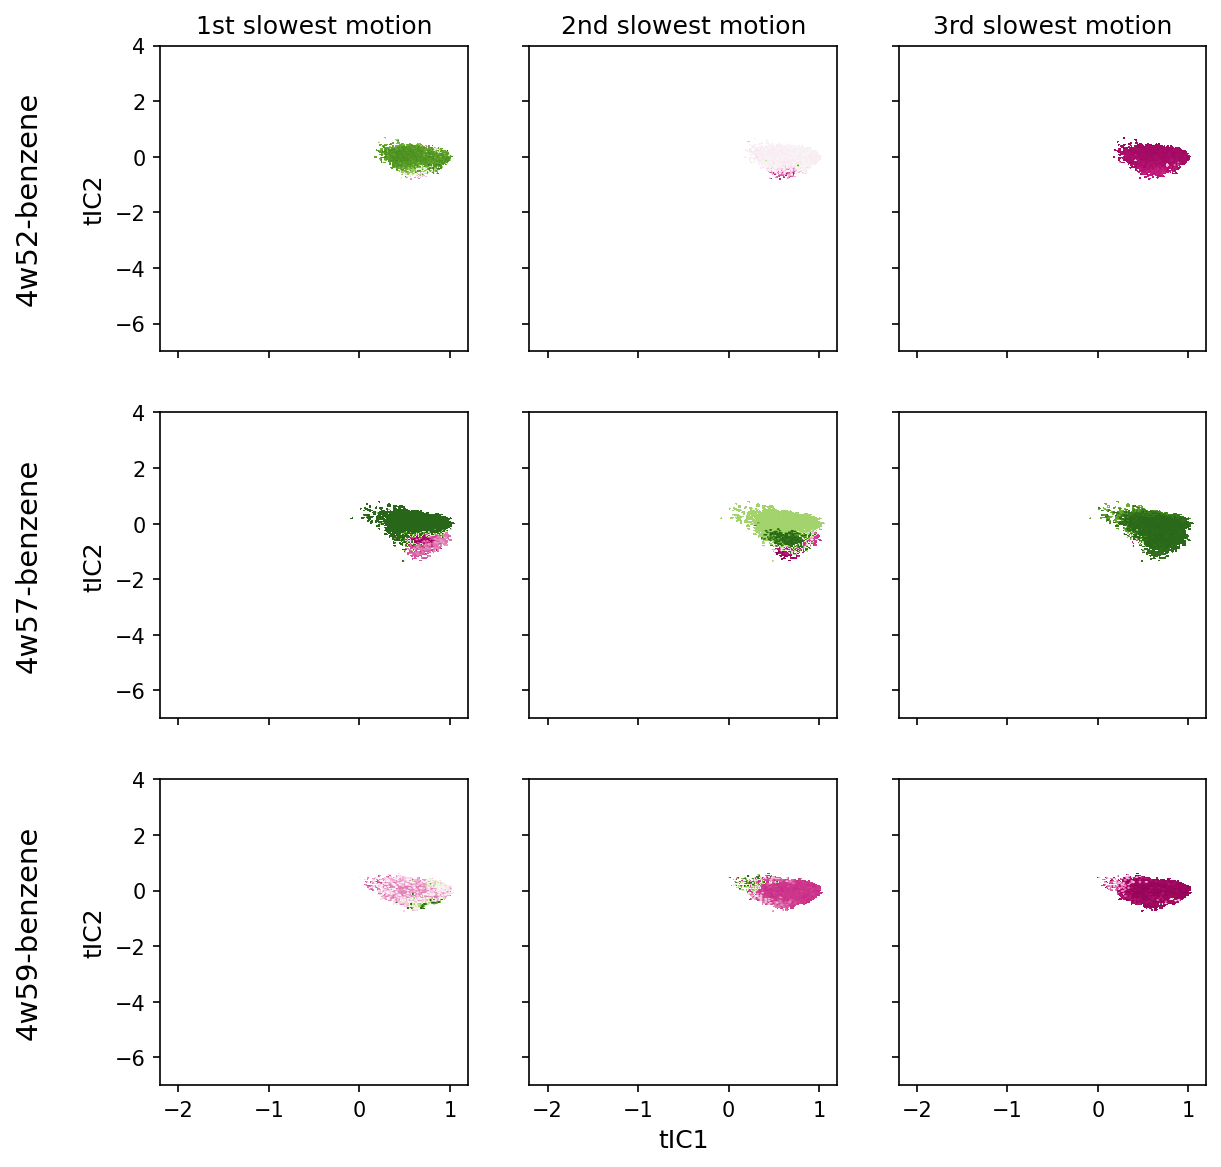

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(9,9), sharex=True, sharey=True, dpi=150)
ticas = [t_52_52, t_57_52, t_59_52]
eigs = [eig_52_52, eig_57_52, eig_59_52]
clusters = [c_52_52, c_57_52, c_59_52]

for i, ax in enumerate(axes.flat):
    ax.set_xlim([-2.2, 1.2])
    ax.set_ylim([-7, 4])
    N = i // 3
    m = i % 3
    pyemma.plots.plot_contour(ticas[N][:,0], ticas[N][:,1], eigs[N][clusters[N], m+1], ax=ax, cmap='PiYG',
                             cbar_label=f'{m+2} right eigenvector', mask=True, cbar=False)

axes[0][0].set_ylabel('tIC2', fontsize=12)
axes[1][0].set_ylabel('tIC2', fontsize=12)
axes[2][0].set_ylabel('tIC2', fontsize=12)

axes[0][1].set_ylabel('4w52-benzene', labelpad=230, fontsize=14)
axes[1][1].set_ylabel('4w57-benzene', labelpad=230, fontsize=14)
axes[2][1].set_ylabel('4w59-benzene', labelpad=230, fontsize=14)

axes[2][1].set_xlabel('tIC1', fontsize=12)

axes[0][0].set_title('1st slowest motion', fontsize=12)
axes[0][1].set_title('2nd slowest motion', fontsize=12)
axes[0][2].set_title('3rd slowest motion', fontsize=12)

#n_ticks = 2
#cbar_ax = fig.add_axes([0.93, 0.14, 0.01, 0.73])
#cbar_ax.set_xlabel("Density", rotation=0, labelpad=5)

#cbar = plt.colorbar(sc, cax=cbar_ax)
#cbar.set_ticks(np.linspace(0, n_frames-100, n_ticks))
#cbar.set_ticklabels([f"{x:.0f}" for x in np.linspace(0, n_frames, n_ticks)])
fig.savefig('figures/benzene_slowest_motions.png')

plt.show()

### Butylbenzene-bound systems

In [22]:
msm_52_57 = m_52_57[selected_lag]
msm_57_57 = m_57_57[selected_lag]
msm_59_57 = m_59_57[selected_lag]

eig_52_57 = eigenvectors(msm_52_57.transition_matrix)
eig_57_57 = eigenvectors(msm_57_57.transition_matrix)
eig_59_57 = eigenvectors(msm_59_57.transition_matrix)

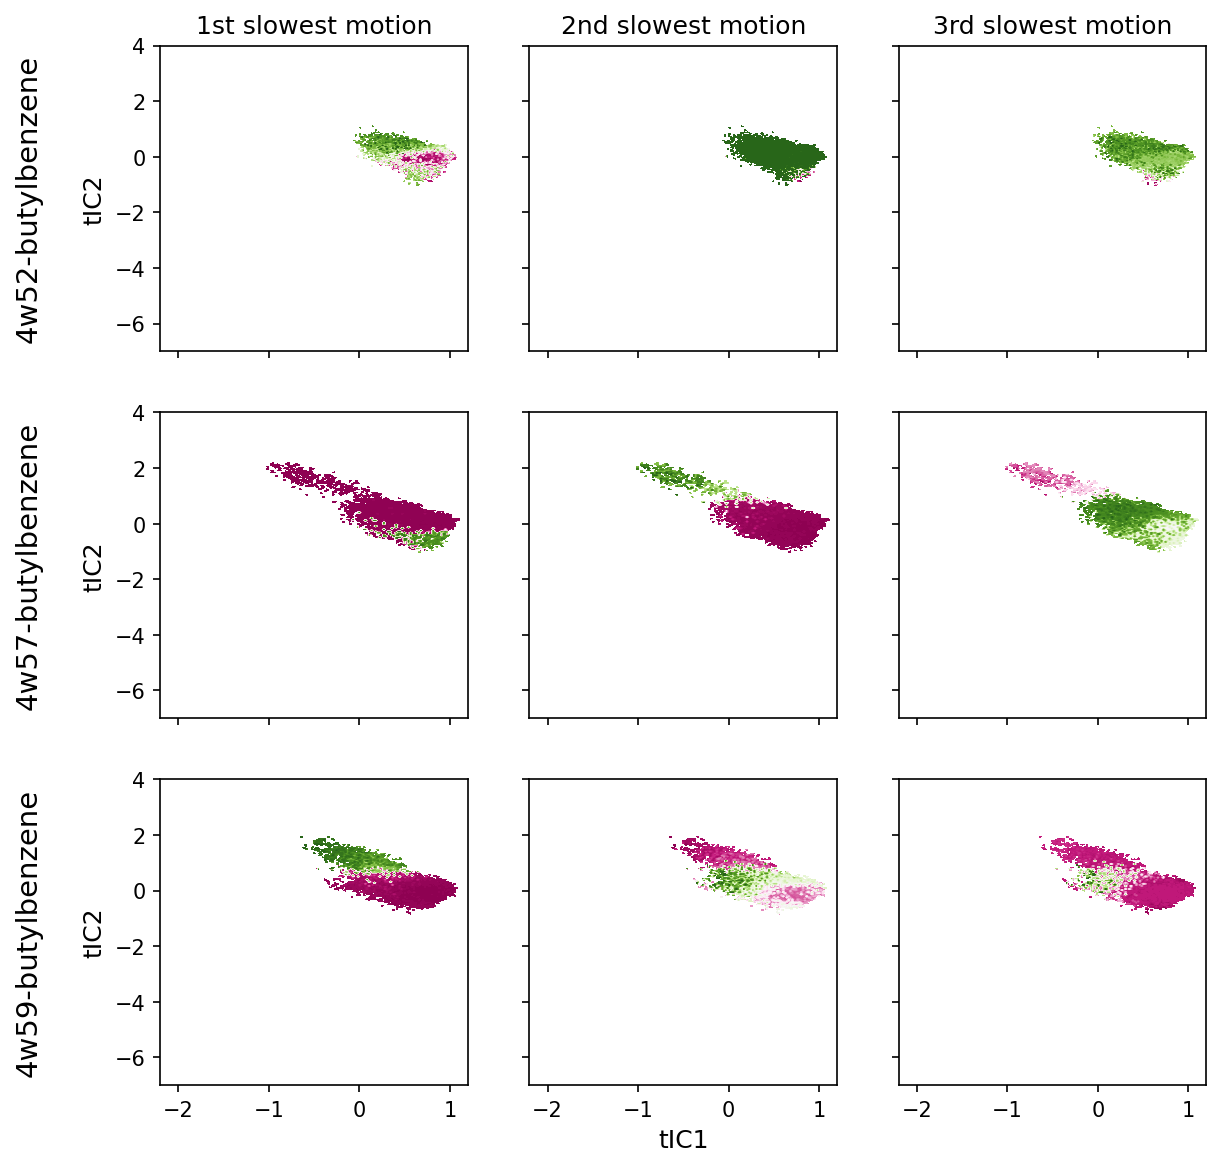

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(9,9), sharex=True, sharey=True, dpi=150)
ticas = [t_52_57, t_57_57, t_59_57]
eigs = [eig_52_57, eig_57_57, eig_59_57]
clusters = [c_52_57, c_57_57, c_59_57]

for i, ax in enumerate(axes.flat):
    ax.set_xlim([-2.2, 1.2])
    ax.set_ylim([-7, 4])
    N = i // 3
    m = i % 3
    pyemma.plots.plot_contour(ticas[N][:,0], ticas[N][:,1], eigs[N][clusters[N], m+1], ax=ax, cmap='PiYG',
                             cbar_label=f'{m+2} right eigenvector', mask=True, cbar=False)

axes[0][0].set_ylabel('tIC2', fontsize=12)
axes[1][0].set_ylabel('tIC2', fontsize=12)
axes[2][0].set_ylabel('tIC2', fontsize=12)

axes[0][1].set_ylabel('4w52-butylbenzene', labelpad=230, fontsize=14)
axes[1][1].set_ylabel('4w57-butylbenzene', labelpad=230, fontsize=14)
axes[2][1].set_ylabel('4w59-butylbenzene', labelpad=230, fontsize=14)

axes[2][1].set_xlabel('tIC1', fontsize=12)

axes[0][0].set_title('1st slowest motion', fontsize=12)
axes[0][1].set_title('2nd slowest motion', fontsize=12)
axes[0][2].set_title('3rd slowest motion', fontsize=12)

#n_ticks = 2
#cbar_ax = fig.add_axes([0.93, 0.14, 0.01, 0.73])
#cbar_ax.set_xlabel("Density", rotation=0, labelpad=5)

#cbar = plt.colorbar(sc, cax=cbar_ax)
#cbar.set_ticks(np.linspace(0, n_frames-100, n_ticks))
#cbar.set_ticklabels([f"{x:.0f}" for x in np.linspace(0, n_frames, n_ticks)])
fig.savefig('figures/butylbenzene_slowest_motions.png')

plt.show()

### Hexylbenzene-bound systems

In [24]:
msm_52_59 = m_52_59[selected_lag]
msm_57_59 = m_57_59[selected_lag]
msm_59_59 = m_59_59[selected_lag]

eig_52_59 = eigenvectors(msm_52_59.transition_matrix)
eig_57_59 = eigenvectors(msm_57_59.transition_matrix)
eig_59_59 = eigenvectors(msm_59_59.transition_matrix)

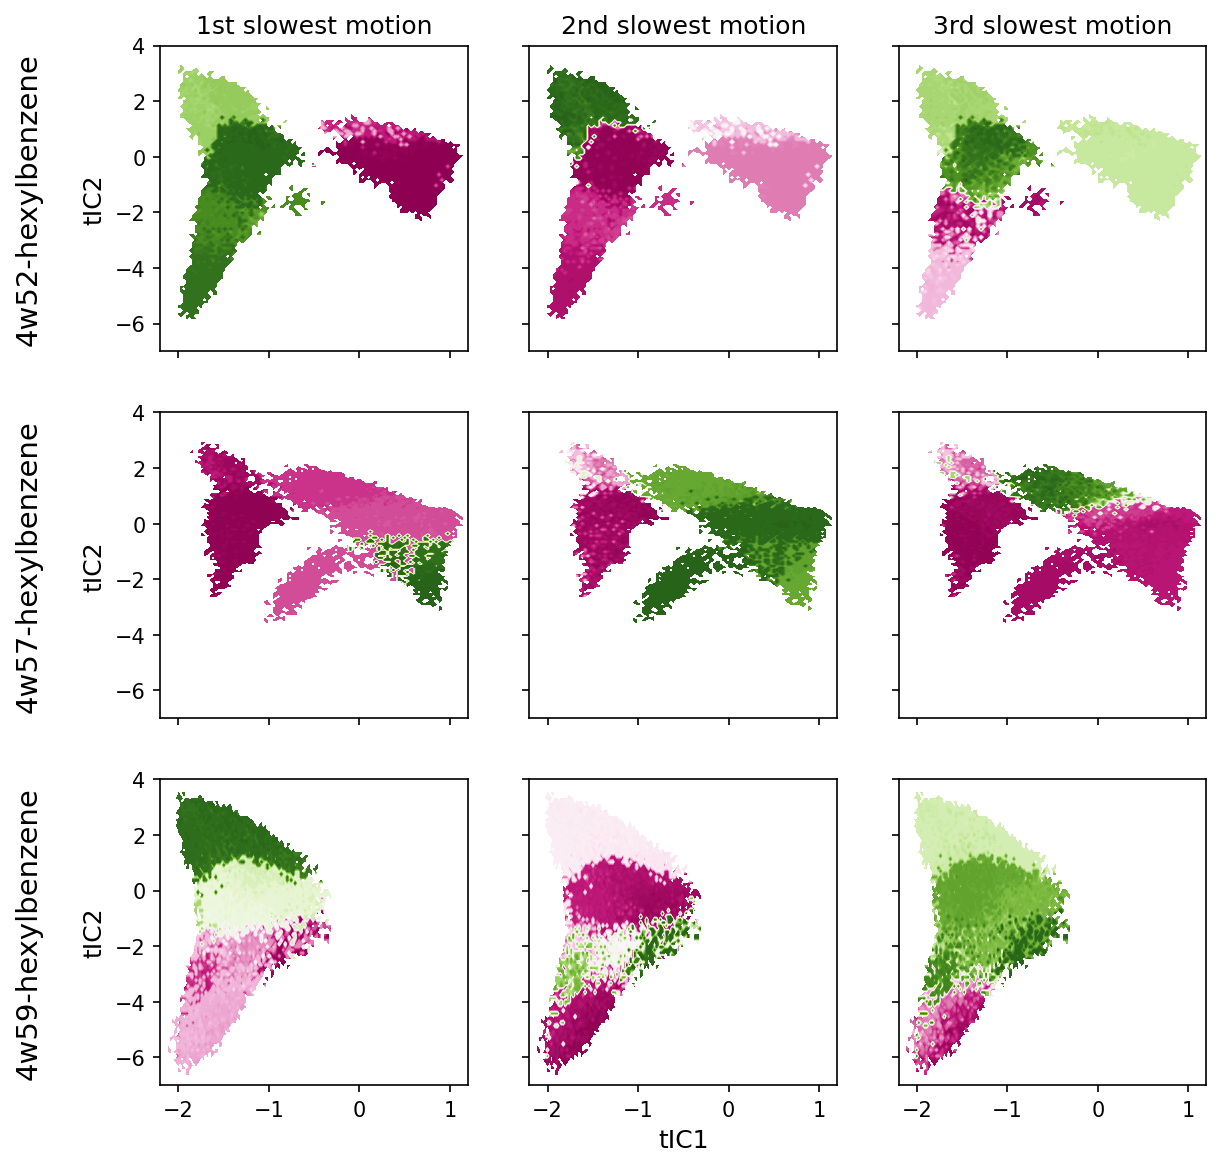

In [40]:
fig, axes = plt.subplots(3, 3, figsize=(9,9), sharex=True, sharey=True, dpi=150)
ticas = [t_52_59, t_57_59, t_59_59]
eigs = [eig_52_59, eig_57_59, eig_59_59]
clusters = [c_52_59, c_57_59, c_59_59]

for i, ax in enumerate(axes.flat):
    ax.set_xlim([-2.2, 1.2])
    ax.set_ylim([-7, 4])
    N = i // 3
    m = i % 3
    pyemma.plots.plot_contour(ticas[N][:,0], ticas[N][:,1], eigs[N][clusters[N], m+1], ax=ax, cmap='PiYG',
                             cbar_label=f'{m+2} right eigenvector', mask=True, cbar=False)

axes[0][0].set_ylabel('tIC2', fontsize=12)
axes[1][0].set_ylabel('tIC2', fontsize=12)
axes[2][0].set_ylabel('tIC2', fontsize=12)

axes[0][1].set_ylabel('4w52-hexylbenzene', labelpad=230, fontsize=14)
axes[1][1].set_ylabel('4w57-hexylbenzene', labelpad=230, fontsize=14)
axes[2][1].set_ylabel('4w59-hexylbenzene', labelpad=230, fontsize=14)

axes[2][1].set_xlabel('tIC1', fontsize=12)

axes[0][0].set_title('1st slowest motion', fontsize=12)
axes[0][1].set_title('2nd slowest motion', fontsize=12)
axes[0][2].set_title('3rd slowest motion', fontsize=12)

#n_ticks = 2
#cbar_ax = fig.add_axes([0.93, 0.14, 0.01, 0.73])
#cbar_ax.set_xlabel("Density", rotation=0, labelpad=5)

#cbar = plt.colorbar(sc, cax=cbar_ax)
#cbar.set_ticks(np.linspace(0, n_frames-100, n_ticks))
#cbar.set_ticklabels([f"{x:.0f}" for x in np.linspace(0, n_frames, n_ticks)])
fig.savefig('figures/hexylbenzene_slowest_motions.png')

plt.show()

## Native system states

From each transition probability matrix, we can apply a spectral clustering method, PCCA+, to resolve macrostates. The number of macrostates we hope to resolve is given as an argument to the function. We can test how many macrostates are reasonable for the system using a Chapman-Kolmogorov test, which we show in the notebooks for each system MSM. To be clear, the number of macrostates we specify for each system is not arbitrary; rather, we test for the appropriate value for each system in their respective MSM notebooks.

In [26]:
# Here, m is the number of macrostates for the system
pcca_52_52 = pcca(msm_52_52.transition_matrix, m=1)
pcca_57_57 = pcca(msm_57_57.transition_matrix, m=1)
pcca_59_59 = pcca(msm_59_59.transition_matrix, m=1)

In [29]:
# We convert the given macrostate IDs to a new labeling system so that macrostate definitions
# are consistent across the different systems and we plot the same macrostates with the same colors
dict_52_52 = {0:1}
dict_57_57 = {0:1}
dict_59_59 = {0:2}

label_52_52 = [dict_52_52[x] for x in pcca_52_52.assignments[c_52_52]]
label_57_57 = [dict_57_57[x] for x in pcca_57_57.assignments[c_57_57]]
label_59_59 = [dict_59_59[x] for x in pcca_59_59.assignments[c_59_59]]

colors = {1:'darkviolet', 2:'limegreen', 3:'deepskyblue', 4:'orange', 5:'gold'}

color_52_52 = [colors[x] for x in label_52_52]
color_57_57 = [colors[x] for x in label_57_57]
color_59_59 = [colors[x] for x in label_59_59]

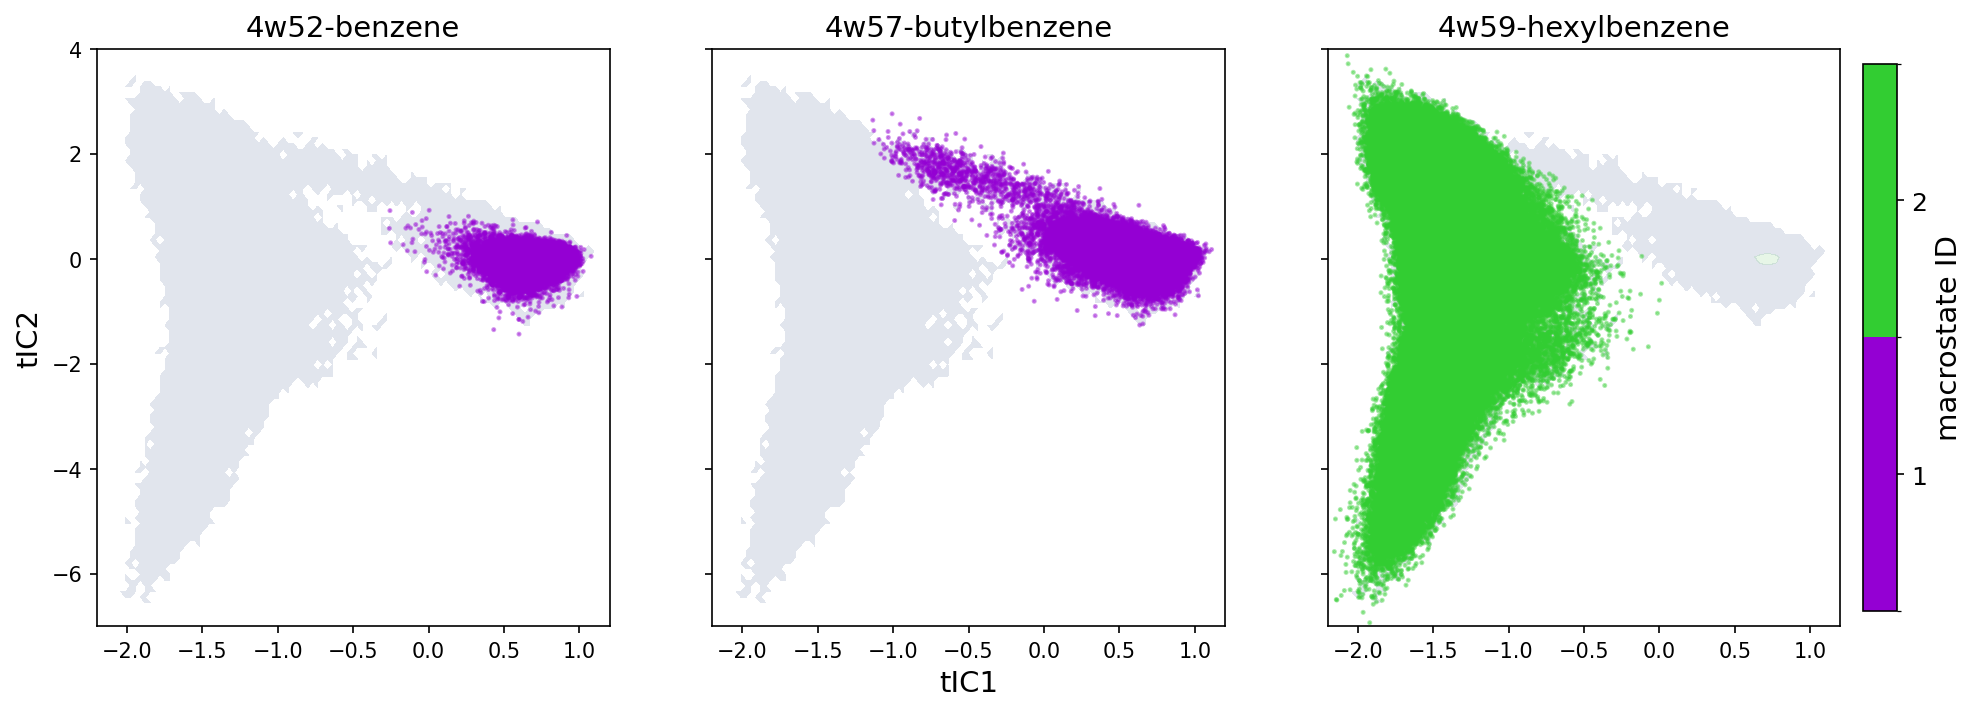

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True, dpi=150)

pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axs[0], alpha=0.15, cbar=False, levels=1)
axs[0].scatter(t_52_52[:,0], t_52_52[:,1], s=2, c=color_52_52, alpha=0.4)
axs[0].set_xlim([-2.2, 1.2])
axs[0].set_ylim([-7, 4])
axs[0].set_ylabel('tIC2', fontsize=14)
axs[0].set_title('4w52-benzene', fontsize=14)

pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axs[1], alpha=0.15, cbar=False, levels=1)
axs[1].scatter(t_57_57[:,0], t_57_57[:,1], s=2, c=color_57_57, alpha=0.4)
axs[1].set_xlim([-2.2, 1.2])
axs[1].set_ylim([-7, 4])
axs[1].set_xlabel('tIC1', fontsize=14)
axs[1].set_title('4w57-butylbenzene', fontsize=14)

pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axs[2], alpha=0.15, cbar=False, levels=1)
axs[2].scatter(t_59_59[:,0], t_59_59[:,1], s=2, c=color_59_59, alpha=0.4)
axs[2].set_xlim([-2.2, 1.2])
axs[2].set_ylim([-7, 4])
axs[2].set_title('4w59-hexylbenzene', fontsize=14)

cmap = mpl.colors.ListedColormap(['darkviolet', 'limegreen'])
bounds = np.arange(0.5, 3.5, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.73])

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax, orientation='vertical',
    spacing='uniform')

cbar_ax.set_yticks(np.arange(1, 3, 1))
cbar_ax.set_yticklabels(np.arange(1, 3, 1), fontsize=12)
cbar_ax.set_ylabel('macrostate ID', fontsize=14)

fig.savefig('figures/native_system_states.png')

plt.show()

## Mixed system states

In [32]:
pcca_57_52 = pcca(msm_57_52.transition_matrix, m=2)
pcca_59_52 = pcca(msm_59_52.transition_matrix, m=1)

pcca_52_57 = pcca(msm_52_57.transition_matrix, m=1)
pcca_59_57 = pcca(msm_59_57.transition_matrix, m=2)

pcca_52_59 = pcca(msm_52_59.transition_matrix, m=2)
pcca_57_59 = pcca(msm_57_59.transition_matrix, m=5)

In [33]:
# Standardize colors
dict_57_52 = {0:4, 1:1}
dict_59_52 = {0:1}

dict_52_57 = {0:1}
dict_59_57 = {0:3, 1:1}

dict_52_59 = {0:2, 1:1}
dict_57_59 = {0:5, 1:3, 2:2, 3:4, 4:1}

label_57_52 = [dict_57_52[x] for x in pcca_57_52.assignments[c_57_52]]
label_59_52 = [dict_59_52[x] for x in pcca_59_52.assignments[c_59_52]]

label_52_57 = [dict_52_57[x] for x in pcca_52_57.assignments[c_52_57]]
label_59_57 = [dict_59_57[x] for x in pcca_59_57.assignments[c_59_57]]

label_52_59 = [dict_52_59[x] for x in pcca_52_59.assignments[c_52_59]]
label_57_59 = [dict_57_59[x] for x in pcca_57_59.assignments[c_57_59]]

colors = {1:'darkviolet', 2:'limegreen', 3:'deepskyblue', 4:'orange', 5:'gold'}
color_57_52 = [colors[x] for x in label_57_52]
color_59_52 = [colors[x] for x in label_59_52]

color_52_57 = [colors[x] for x in label_52_57]
color_59_57 = [colors[x] for x in label_59_57]

color_52_59 = [colors[x] for x in label_52_59]
color_57_59 = [colors[x] for x in label_57_59]

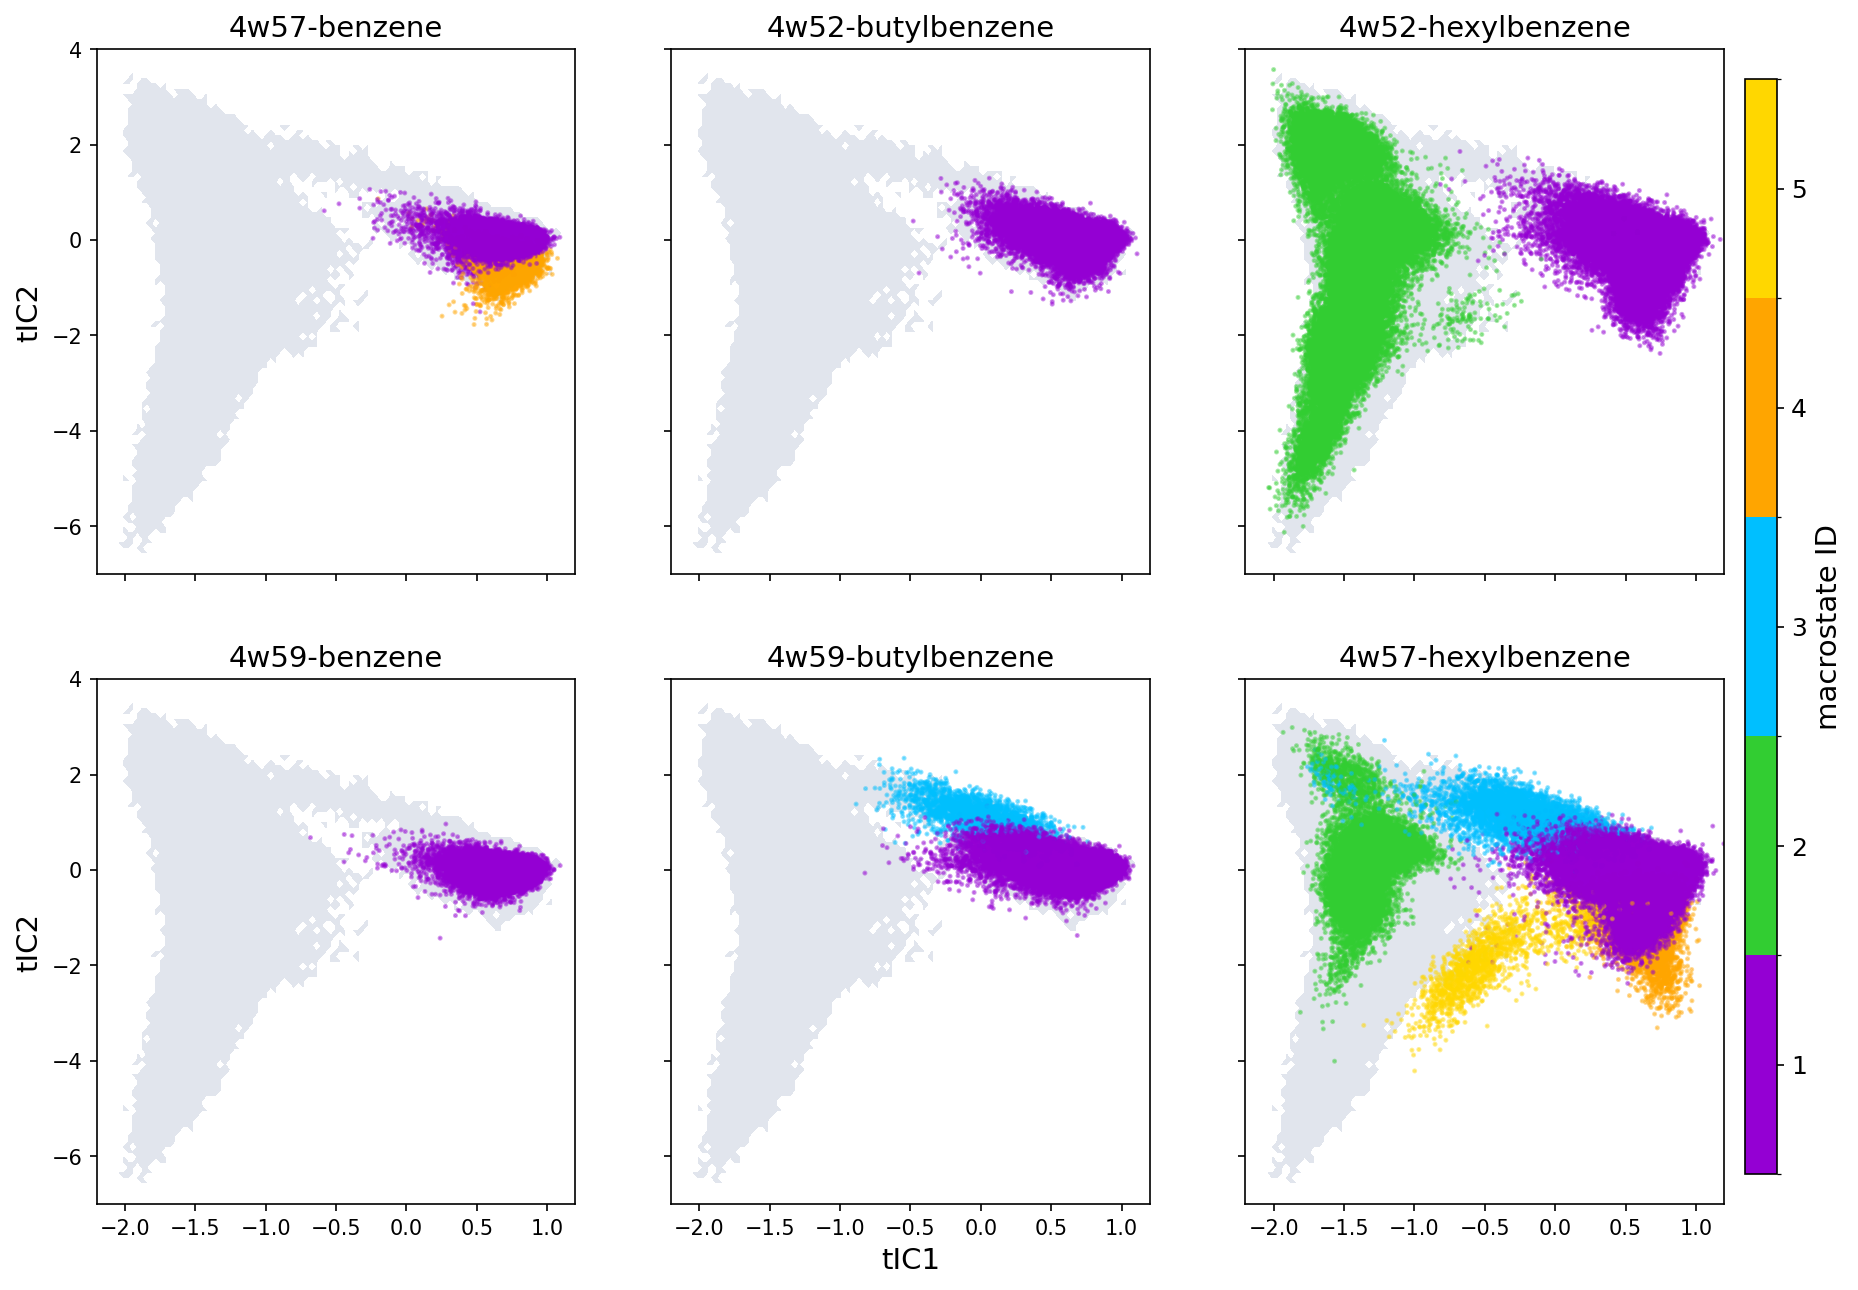

In [42]:
ticas = [t_57_52, t_52_57, t_52_59, t_59_52, t_59_57, t_57_59]
pccas = [pcca_57_52, pcca_52_57, pcca_52_59, pcca_59_52, pcca_59_57, pcca_57_59]
cluster_assigns = [c_57_52, c_52_57, c_52_59, c_59_52, c_59_57, c_57_59]
colors = [color_57_52, color_52_57, color_52_59, color_59_52, color_59_57, color_57_59]
titles = ['4w57-benzene', '4w52-butylbenzene', '4w52-hexylbenzene',
          '4w59-benzene', '4w59-butylbenzene', '4w57-hexylbenzene']

fig, axs = plt.subplots(2, 3, figsize=(14,10), sharex=True, sharey=True, dpi=150)

for index, ax in enumerate(axs.reshape(-1)):
    ax.set_xlim([-2.2, 1.2])
    ax.set_ylim([-7, 4])
    pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=ax, alpha=0.15, cbar=False, levels=1)
    ax.scatter(ticas[index][:,0], ticas[index][:,1], s=2, c=colors[index], alpha=0.4)
    ax.set_title(titles[index], fontsize=14)

axs[0][0].set_ylabel('tIC2', fontsize=14)
axs[1][0].set_ylabel('tIC2', fontsize=14)
axs[1][1].set_xlabel('tIC1', fontsize=14)

cmap = mpl.colors.ListedColormap(['darkviolet', 'limegreen', 'deepskyblue', 'orange', 'gold'])
bounds = np.arange(0.5, 6.5, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.73])

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax, orientation='vertical',
    spacing='uniform')

cbar_ax.set_yticks(np.arange(1, 6, 1))
cbar_ax.set_yticklabels(np.arange(1, 6, 1), fontsize=12)
cbar_ax.set_ylabel('macrostate ID', fontsize=14)

fig.savefig('figures/mixed_system_states.png')
plt.show()

## Timescale estimates

In [35]:
from deeptime.markov.tools.analysis import mfpt
lagtimes = np.array([100, 150, 250, 350, 500, 750, 1000])

### Description

We estimate transition timescales between the resolved discrete states by calculating the mean first passage time (MFPT). We focus in on transitions among the three discretes corresponding to experiment -- closed, open and intermediate -- which correspond to our macrostate IDs 1, 2 and 3, respectively.

Since we convert the PCCA state IDs to a different numbering system to keep macrostate IDs consistent across systems, we need to convert again to ensure we are calculating the correct MFPT. 

For each transition, we first look up in the state dictionary the index which corresponds to the correct macrostate. For example, the closed state corresponds to macrostate ID 1. We find that in the 4w59-butylbenzene system, macrostate ID 1 is an index of 1 (e.g. `dict_59_57[1] == 1`). Thus, we use `index==1` to find the transitions to and from the closed state in the 4w59-butylbenzene system. 

### closed <-> intermediate (macrostate 1 <-> macrostate 3)

#### 4w59-butylbenzene estimates

In [44]:
# determine which values map to the macrostate ids
print('4w59-butylbenzene system:')
print(f'closed state macrostate id: {dict_59_57[1]}, index: {1}')
print(f'int state macrostate id: {dict_59_57[0]}, index: {0}')

4w59-butylbenzene system:
closed state macrostate id: 1, index: 1
int state macrostate id: 3, index: 0


In [45]:
m_59_57_to_closed = mfpt(pcca_59_57.coarse_grained_transition_matrix, target=1, tau=lagtimes[selected_lag])
m_59_57_to_int = mfpt(pcca_59_57.coarse_grained_transition_matrix, target=0, tau=lagtimes[selected_lag])
print('4w59-butylbenzene estimates:')
print(f'int to closed: {m_59_57_to_closed[0]*0.002:.2f} ns')
print(f'closed to int: {m_59_57_to_int[1]*0.002:.2f} ns' )

4w59-butylbenzene estimates:
int to closed: 4.16 ns
closed to int: 495.43 ns


#### 4w57-hexylbenzene estimates

In [61]:
# determine which values map to the macrostate ids
print('4w57-hexylbenzene system:')
print(f'closed state macrostate id: {dict_57_59[4]}, index: {4}')
print(f'int state macrostate id: {dict_57_59[1]}, index: {1}')

4w57-hexylbenzene system:
closed state macrostate id: 1, index: 4
int state macrostate id: 3, index: 1


In [62]:
m_57_59_to_closed = mfpt(pcca_57_59.coarse_grained_transition_matrix, target=4, tau=lagtimes[selected_lag])
m_57_59_to_int = mfpt(pcca_57_59.coarse_grained_transition_matrix, target=1, tau=lagtimes[selected_lag])
print('4w57-hexylbenzene estimates:')
print(f'int to closed: {m_57_59_to_closed[1]*0.002:.2f} ns')
print(f'closed to int: {m_57_59_to_int[4]*0.002:.2f} ns' )

4w57-hexylbenzene estimates:
int to closed: 10.14 ns
closed to int: 201.78 ns


### intermediate <-> open (macrostate 3 <-> macrostate 2)

#### 4w57-hexylbenzene estimates

In [66]:
# determine which values map to the macrostate ids
print('4w57-hexylbenzene system:')
print(f'int state macrostate id: {dict_57_59[1]}, index: {1}')
print(f'open state macrostate id: {dict_57_59[2]}, index: {2}')

4w57-hexylbenzene system:
int state macrostate id: 3, index: 1
open state macrostate id: 2, index: 2


In [67]:
m_57_59_to_int = mfpt(pcca_57_59.coarse_grained_transition_matrix, target=1, tau=lagtimes[selected_lag])
m_57_59_to_open = mfpt(pcca_57_59.coarse_grained_transition_matrix, target=2, tau=lagtimes[selected_lag])
print('4w57-hexylbenzene estimates:')
print(f'int to open: {m_57_59_to_open[1]*0.002:.2f} ns')
print(f'open to int: {m_57_59_to_int[2]*0.002:.2f} ns' )

4w57-hexylbenzene estimates:
int to open: 853.70 ns
open to int: 131.20 ns


### closed <-> open (macrostate 1 <-> macrostate 2)

#### 4w52-hexylbenzene estimates

In [69]:
# determine which values map to the macrostate ids
print('4w52-hexylbenzene system:')
print(f'closed state macrostate id: {dict_52_59[1]}, index: {1}')
print(f'open state macrostate id: {dict_52_59[0]}, index: {0}')

4w52-hexylbenzene system:
closed state macrostate id: 1, index: 1
open state macrostate id: 2, index: 0


In [70]:
m_52_59_to_closed = mfpt(pcca_52_59.coarse_grained_transition_matrix, target=1, tau=lagtimes[selected_lag])
m_52_59_to_open = mfpt(pcca_52_59.coarse_grained_transition_matrix, target=0, tau=lagtimes[selected_lag])
print('4w52-hexylbenzene estimates:')
print(f'closed to open: {m_52_59_to_open[1]*0.002:.2f} ns')
print(f'open to closed: {m_52_59_to_closed[0]*0.002:.2f} ns')

4w52-hexylbenzene estimates:
closed to open: 1229.54 ns
open to closed: 115.59 ns


#### 4w57-hexylbenzene estimates

In [78]:
# determine which values map to the macrostate ids
print('4w57-hexylbenzene system:')
print(f'closed state macrostate id: {dict_57_59[4]}, index: {4}')
print(f'open state macrostate id: {dict_57_59[2]}, index: {2}')

4w57-hexylbenzene system:
closed state macrostate id: 1, index: 4
open state macrostate id: 2, index: 2


In [80]:
m_57_59_to_closed = mfpt(pcca_57_59.coarse_grained_transition_matrix, target=4, tau=lagtimes[selected_lag])
m_57_59_to_open = mfpt(pcca_57_59.coarse_grained_transition_matrix, target=2, tau=lagtimes[selected_lag])

print('4w57-hexylbenzene estimates:')
print(f'closed to open: {m_57_59_to_open[4]*0.002:.2f} ns')
print(f'open to closed: {m_57_59_to_closed[2]*0.002:.2f} ns' )

4w57-hexylbenzene estimates:
closed to open: 985.08 ns
open to closed: 37.46 ns


### Select representative frames along TICA surface

For reseachers who may be interested in examining the structure of the F-helix at different points along the TICA surface, we provide a couple examples. We show where each structure falls on the TICA surface. Each structure will be saved as a different numbered pdb files in the Supporting Information. 

In [84]:
tic1, tic2 = t_57_59[:,0], t_57_59[:,1]

In [85]:
frame_1 = np.where((tic1 < 1) & (tic1 > 0) & (tic2 < -1) & (tic2 > -2) & (np.array(label_57_59) == 1))[0][0]
frame_2 = np.where((tic1 < -1) & (tic1 > -2) & (tic2 < 0) & (tic2 > -2) & (np.array(label_57_59) == 2))[0][0]
frame_3 = np.where((tic1 < -0.5) & (tic1 > -1) & (tic2 < 2) & (tic2 > 1) & (np.array(label_57_59) == 3))[0][0]
frame_4 = np.where((tic1 < 1) & (tic1 > 0.5) & (tic2 < -2) & (tic2 > -4) & (np.array(label_57_59) == 4))[0][0]
frame_5 = np.where((tic1 < -0.3) & (tic1 > -1) & (tic2 < -2) & (tic2 > -4) & (np.array(label_57_59) == 5))[0][0]

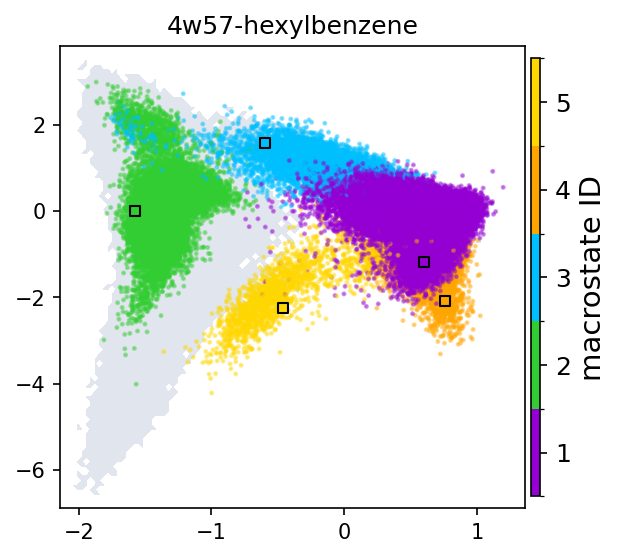

In [86]:
fig, axs = plt.subplots(figsize=(4,4), dpi=150)
pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axs, alpha=0.15, cbar=False, levels=1)
axs.scatter(t_57_59[:,0], t_57_59[:,1], s=2, c=color_57_59, alpha=0.4)
axs.scatter(t_57_59[frame_1,0], t_57_59[frame_1,1], s=20, c=color_57_59[frame_1], marker='s', edgecolor='black')
axs.scatter(t_57_59[frame_2,0], t_57_59[frame_2,1], s=20, c=color_57_59[frame_2], marker='s', edgecolor='black')
axs.scatter(t_57_59[frame_3,0], t_57_59[frame_3,1], s=20, c=color_57_59[frame_3], marker='s', edgecolor='black')
axs.scatter(t_57_59[frame_4,0], t_57_59[frame_4,1], s=20, c=color_57_59[frame_4], marker='s', edgecolor='black')
axs.scatter(t_57_59[frame_5,0], t_57_59[frame_5,1], s=20, c=color_57_59[frame_5], marker='s', edgecolor='black')

axs.set_title('4w57-hexylbenzene')

cmap = mpl.colors.ListedColormap(['darkviolet', 'limegreen', 'deepskyblue', 'orange', 'gold'])
bounds = np.arange(0.5, 6.5, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.73])

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax, orientation='vertical',
    spacing='uniform')

cbar_ax.set_yticks(np.arange(1, 6, 1))
cbar_ax.set_yticklabels(np.arange(1, 6, 1), fontsize=12)
cbar_ax.set_ylabel('macrostate ID', fontsize=14)

fig.savefig('4w57-hexylbenzene_frames.png')
plt.show()

In [87]:
traj_path='/dfs9/dmobley-lab/osatom/msm_project/trajectories/'
traj_4w57_hexyl = md.load([traj_path + f'4w57_4w59/{x}/F-helix-centered.xtc' for x in range(10)], top=traj_path + '4w57_4w59/0/F-helix-centered.pdb')


In [88]:
traj_4w57_hexyl[frame_1].save_pdb('macrostate_1_snapshot.pdb')
traj_4w57_hexyl[frame_2].save_pdb('macrostate_2_snapshot.pdb')
traj_4w57_hexyl[frame_3].save_pdb('macrostate_3_snapshot.pdb')
traj_4w57_hexyl[frame_4].save_pdb('macrostate_4_snapshot.pdb')
traj_4w57_hexyl[frame_5].save_pdb('macrostate_5_snapshot.pdb')